## Time Series Forecasting with ARIMA-LSTM Ensemble

### EDA

In [53]:
import matplotlib.pyplot as plt

def plot_time_series(df):
    # Group the data
    grouped = df.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category'])

    # Set up the plot
    fig, axs = plt.subplots(8, 6, figsize=(30, 40))
    fig.suptitle('48 Time Series Plots', fontsize=16)

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    for i, (group_key, group) in enumerate(grouped):
        # Plot the time series
        axs[i].plot(group.index, group['volume_kg'])

        # Set title and labels
        axs[i].set_title(f"Series {i+1}: {'-'.join(map(str, group_key))}", fontsize=8)
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Volume (kg)')

        # Rotate x-axis labels for better readability
        axs[i].tick_params(axis='x', rotation=45)

        # Adjust y-axis to start from 0
        axs[i].set_ylim(bottom=0)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    print("Time series plots displayed")

Detected seasonality of 11 months
Detected seasonality of 12 months
Detected seasonality of 3 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 6 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 6 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 24 months
Detected seasonality of 6 months
Detected seasonality of 12 months
Detected seasonality of 4 months
Detected seasonality of 6 months
Detected seasonality of 12 months
Detected seasonality of 7 months
Detected seasonality of 6 months
Detected seasonality of 3 months
Detected seasonality of 3 months
Detected seasonality of 5 months
Detected seasonality of 1

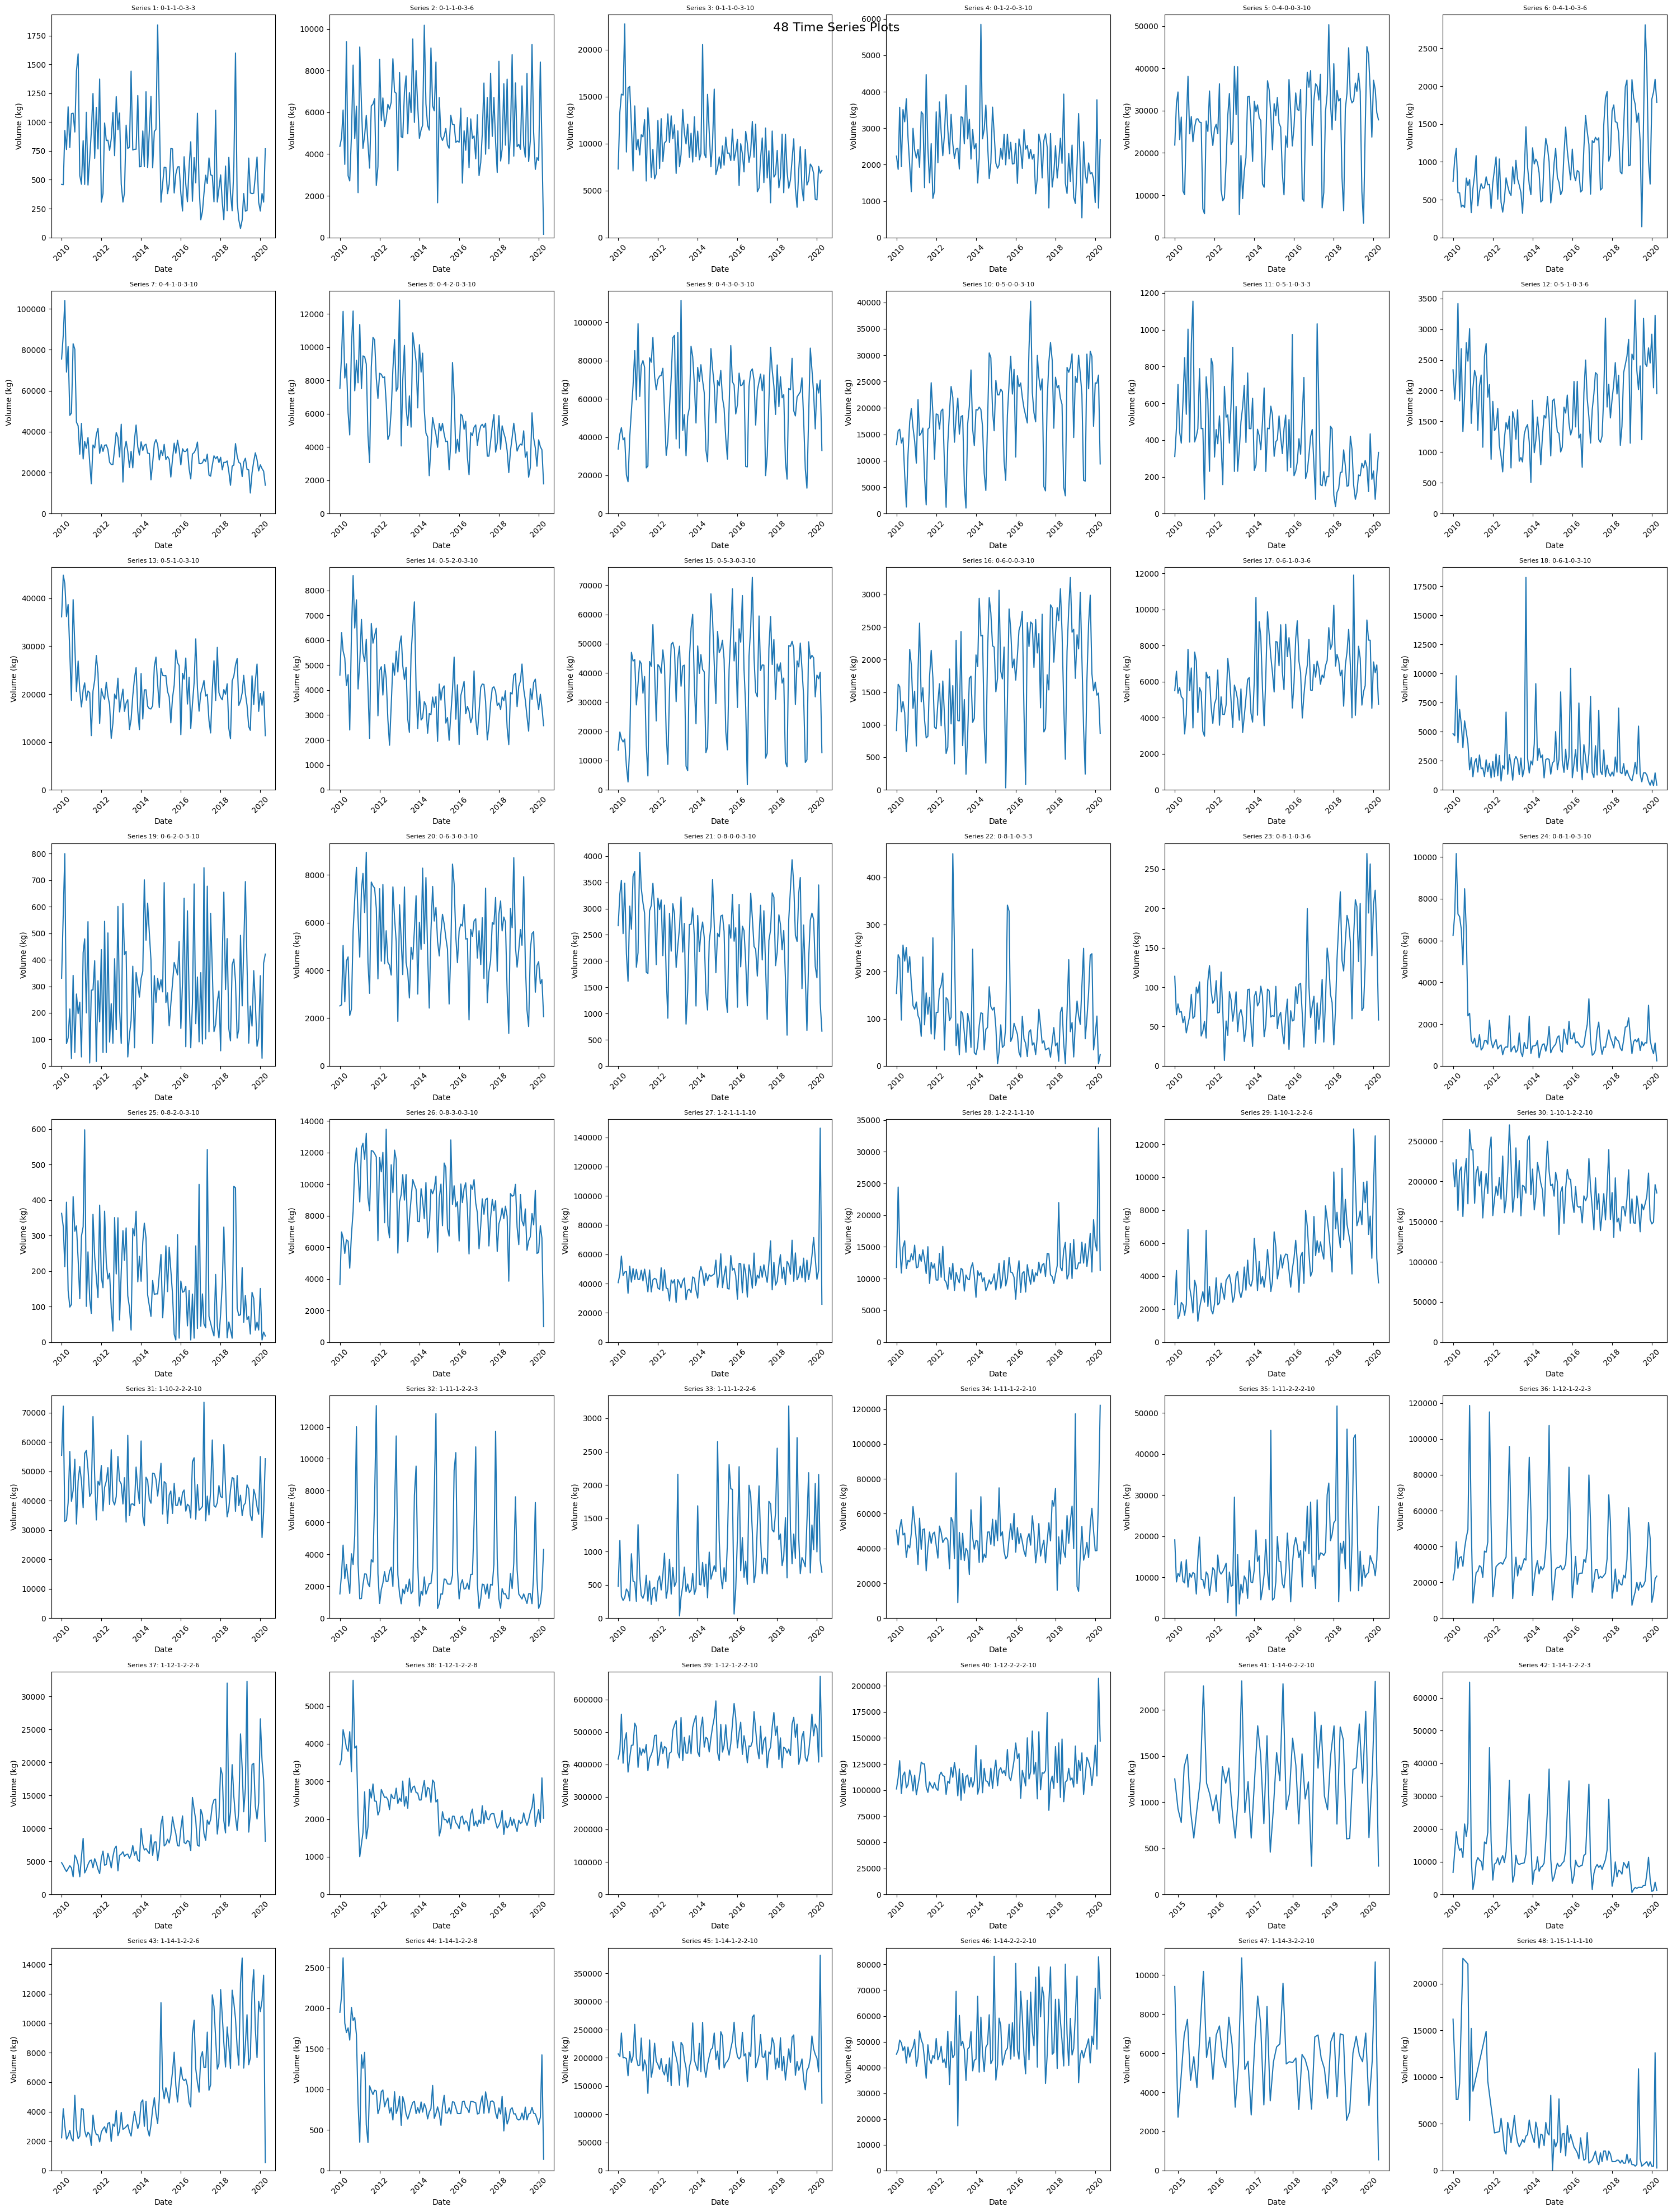

Time series plots displayed


In [54]:
# Load and prepare data
df = prepare_data('data/train.csv')

# Add this line to display the time series plots
plot_time_series(df)

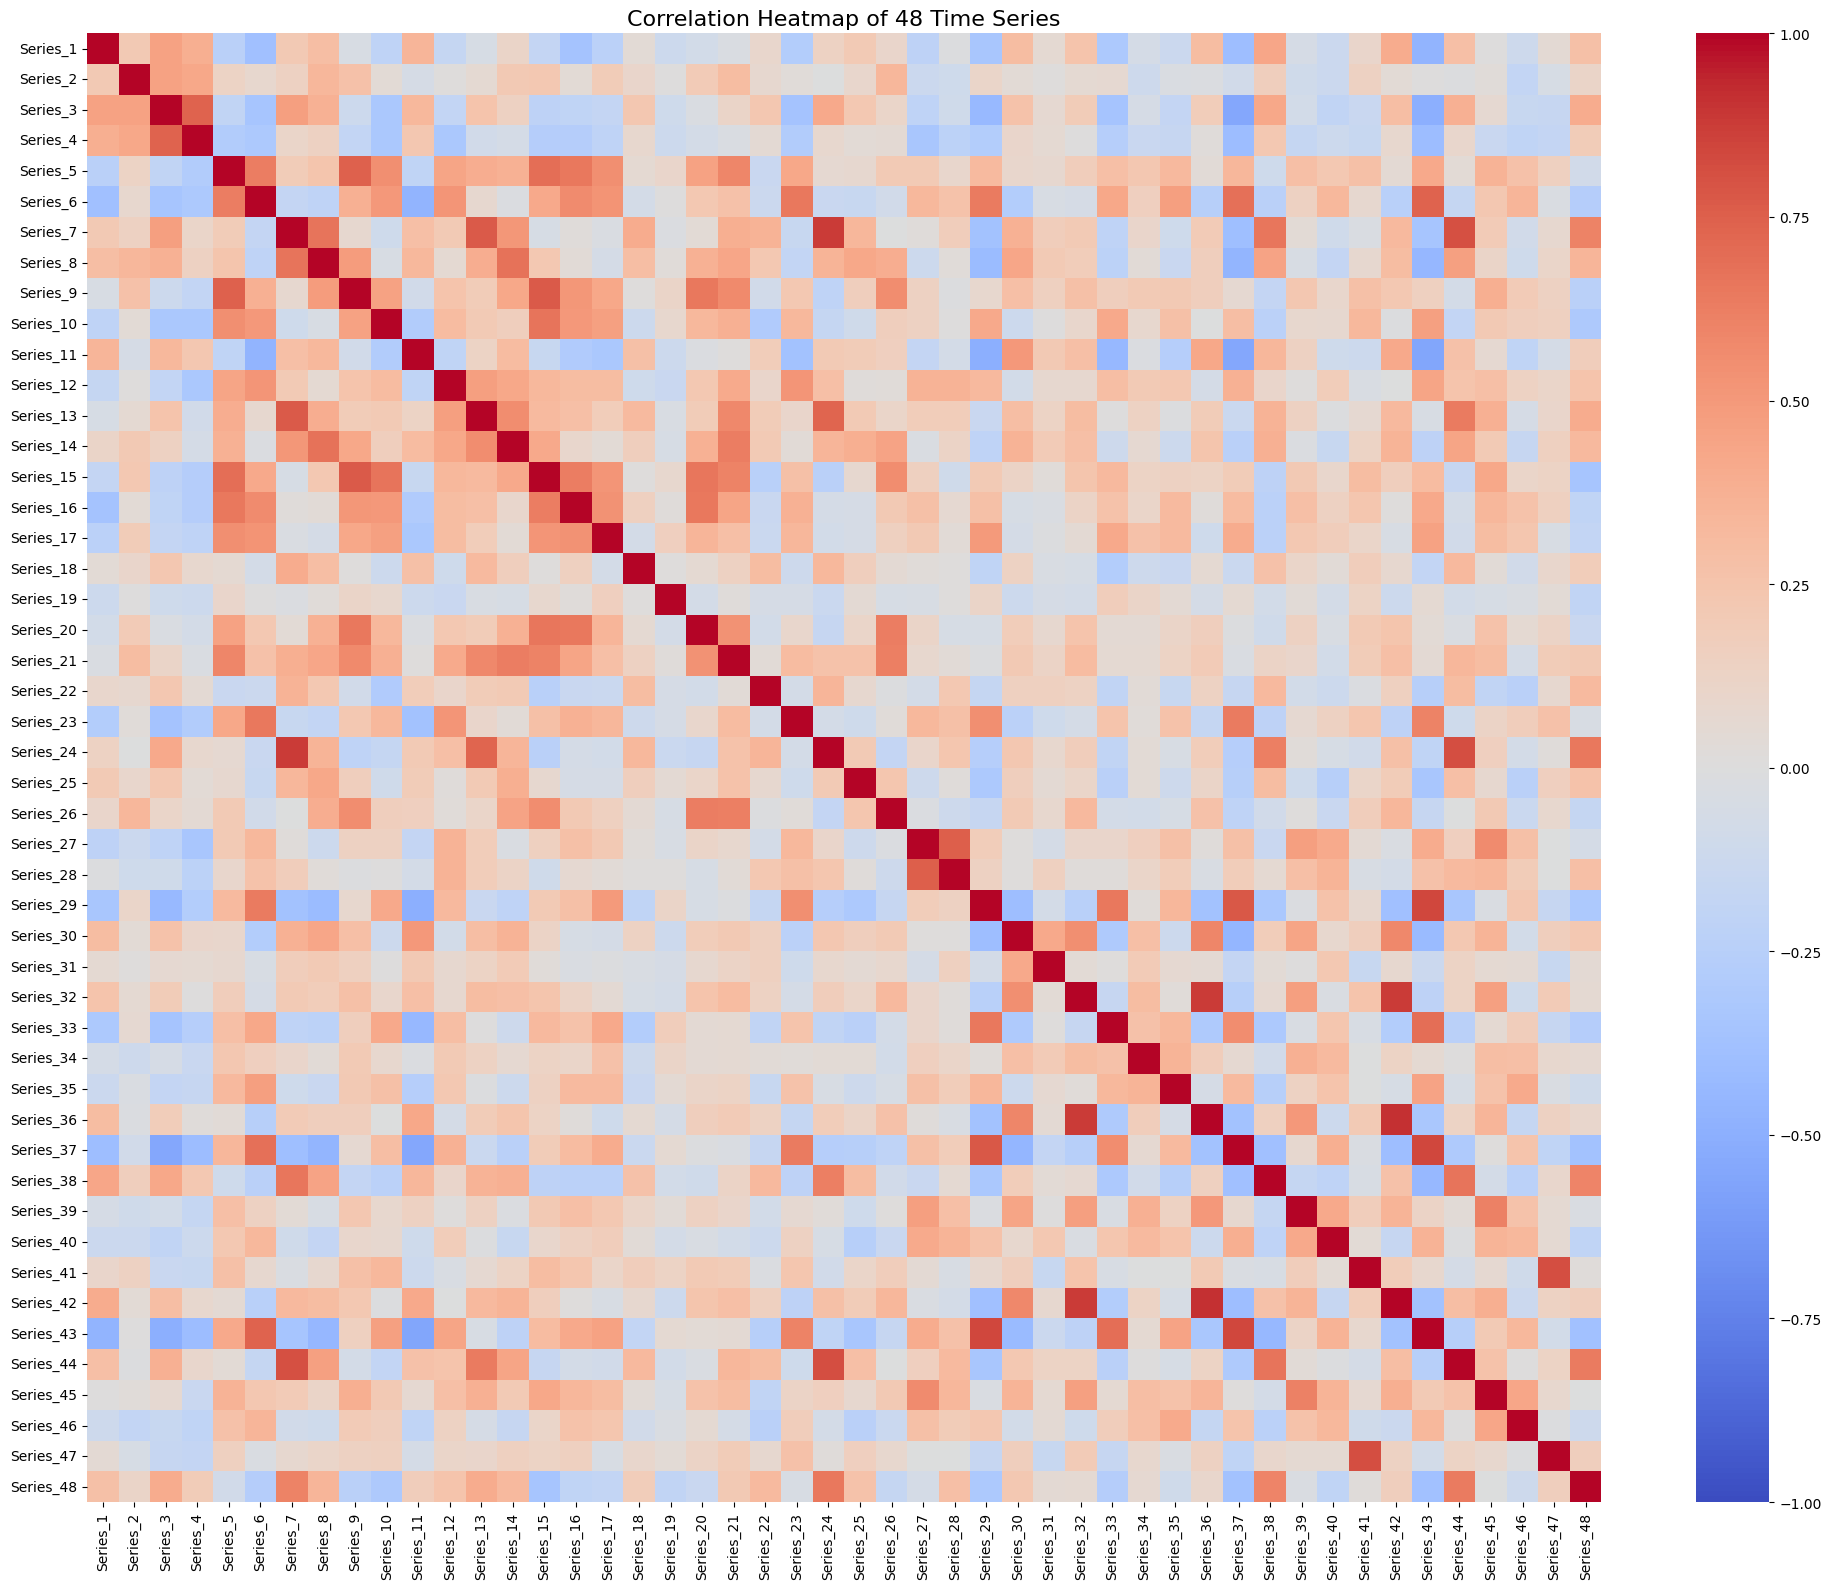

Correlation heatmap displayed


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_heatmap(df):
    # Group the data
    grouped = df.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category'])

    # Create a dictionary to store all series
    series_dict = {}

    # Extract each series and store in the dictionary
    for i, (group_key, group) in enumerate(grouped):
        series_name = f"Series_{i+1}"
        # Ensure the index is unique by resetting it
        series_dict[series_name] = group.reset_index(drop=True)['volume_kg']

    # Create a DataFrame with all series
    combined_df = pd.DataFrame(series_dict)

    # Compute the correlation matrix
    corr_matrix = combined_df.corr(method='pearson')

    # Create the heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of 48 Time Series', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("Correlation heatmap displayed")

    # Optional: return the correlation matrix for further analysis
    return corr_matrix

# Add this line after loading and preparing the data
correlation_matrix = plot_correlation_heatmap(df)

### Data Preparation and Feature Engineering

This section focuses on data loading, preprocessing, and feature engineering. It includes seasonality detection and Fourier feature creation for each time series group, which helps capture cyclical patterns in the data.

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error
import itertools
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


channel_dict = {'FOOD SERVICE': 0, 'DISCOUNTS': 1, 'MODERN TRADE': 2}
channel_dict_inverted = {v: k for k, v in channel_dict.items()}

In [44]:
from statsmodels.tsa.stattools import acf

def detect_seasonality(series, max_lag=36):  # max_lag of 36 allows for up to 3-year seasonality
    """
    Detect seasonality in a time series using autocorrelation.
    Returns the lag with the highest autocorrelation.
    """
    series = series.dropna()
    if len(series) <= max_lag:
        return None

    acf_values = acf(series, nlags=max_lag)

    # Find peaks in ACF
    peaks = np.where((acf_values[1:-1] > acf_values[:-2]) &
                     (acf_values[1:-1] > acf_values[2:]))[0] + 1

    if len(peaks) == 0:
        return None

    # Return the peak with the highest correlation
    return peaks[np.argmax(acf_values[peaks])]

In [45]:
def create_fourier_features(dates, series, num_terms=1):
    seasonality = detect_seasonality(series)
    if seasonality is None:
        print("No clear seasonality detected. Using 12 months as default.")
        seasonality = 12
    else:
        print(f"Detected seasonality of {seasonality} months")

    time = np.array((dates - dates.min()) / np.timedelta64(1, 'M')).astype(float)
    features = np.column_stack([
        np.cos(2 * np.pi * i * time / seasonality) for i in range(1, num_terms + 1)
    ] + [
        np.sin(2 * np.pi * i * time / seasonality) for i in range(1, num_terms + 1)
    ])
    return features

In [46]:
def prepare_data(file_path):
    df = pd.read_csv(file_path)
    df['channel'] = df['channel'].apply(lambda x: channel_dict[x])
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df.set_index('date', inplace=True)

    # Add rolling mean with a minimum number of periods
    df['rolling_mean'] = df['volume_kg'].rolling(window=3, min_periods=1).mean()

    # Add month as a cyclical feature (only sine)
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)

    # Group the data
    grouped = df.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category'])

    # Create a new DataFrame to store Fourier features
    fourier_df = pd.DataFrame(index=df.index)

    for group_name, group in grouped:
        fourier_features = create_fourier_features(group.index, group['volume_kg'])
        for i in range(fourier_features.shape[1]):
            col_name = f'fourier_{i}_{"-".join(map(str, group_name))}'
            fourier_df[col_name] = pd.Series(index=group.index, data=fourier_features[:, i])

    # Combine the original DataFrame with Fourier features
    df = pd.concat([df, fourier_df], axis=1)

    # Forward fill NaN values created by rolling calculations and Fourier features
    df = df.fillna(method='ffill').fillna(method='bfill')

    return df

### Model Definition and Training

This section defines the core modeling functions. It includes an ARIMA model for traditional statistical forecasting and an LSTM model for deep learning-based forecasting. The LSTM model uses time series cross-validation for robust performance estimation.

In [47]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), :])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

def arima_forecast(series, steps):
    print(f"In arima_forecast - Length of series: {len(series)}, steps: {steps}")
    try:
        model = ARIMA(series, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=steps)
        if np.isnan(forecast).any():
            raise ValueError("ARIMA produced NaN values")
    except Exception as e:
        print(f"ARIMA forecast failed: {e}")
        # Fall back to simple moving average
        forecast = np.array([series.iloc[-3:].mean()] * steps)

    forecast = np.maximum(forecast, 0)  # Ensure no negative values
    return forecast


In [48]:
def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))
    return 100. * K.mean(diff, axis=-1)

def lstm_forecast(series, steps, additional_features):
    print(f"In lstm_forecast - Length of series: {len(series)}, steps: {steps}, shape of additional_features: {additional_features.shape}")

    # Use only the features corresponding to the historical data and forecast period
    features_to_use = additional_features[:len(series) + steps, :]

    # Combine series with additional features
    data = np.column_stack((series.values.reshape(-1, 1), features_to_use[:len(series)]))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    look_back = min(6, len(series) - 1) #4
    X, Y = create_dataset(scaled_data, look_back)

    print(f"Shape of X: {X.shape}, Shape of Y: {Y.shape}")

    model = Sequential([
        LSTM(50, input_shape=(look_back, X.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(loss=mean_absolute_percentage_error, optimizer='adam', metrics=[mean_absolute_percentage_error])

    # Perform time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]

        try:
            model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)
            _, mape = model.evaluate(X_val, Y_val, verbose=0)
            cv_scores.append(mape)
        except Exception as e:
            print(f"Error during cross-validation: {e}")
            cv_scores.append(np.nan)

    print(f"Cross-validation MAPE scores: {cv_scores}")
    print(f"Mean CV MAPE score: {np.nanmean(cv_scores)}")

    # Retrain on full dataset
    try:
        model.fit(X, Y, epochs=30, batch_size=24, verbose=1)
    except Exception as e:
        print(f"Error during final training: {e}")
        return np.array([np.nan] * steps), cv_scores

    # Prepare input for forecasting
    input_data = scaled_data[-look_back:]
    input_data = np.reshape(input_data, (1, look_back, X.shape[2]))

    forecasts = []
    for i in range(steps):
        try:
            forecast = model.predict(input_data, verbose=0)
            forecasts.append(forecast[0,0])
        except Exception as e:
            print(f"Error during prediction step {i+1}: {e}")
            forecasts.append(np.nan)

        # Prepare next input
        next_input = np.zeros((1, 1, X.shape[2]))
        next_input[0, 0, 0] = forecast[0,0] if not np.isnan(forecast[0,0]) else 0
        if len(series) + i < len(features_to_use):
            next_input[0, 0, 1:] = features_to_use[len(series) + i]
        else:
            next_input[0, 0, 1:] = features_to_use[-1, :]

        # Scale the next input
        next_input_scaled = scaler.transform(next_input.reshape(1, -1))
        next_input_scaled = next_input_scaled.reshape(1, 1, -1)

        input_data = np.concatenate((input_data[:, 1:, :], next_input_scaled), axis=1)

    forecasts = np.array(forecasts).reshape(-1, 1)
    forecasts = scaler.inverse_transform(np.column_stack((forecasts, np.zeros((len(forecasts), scaled_data.shape[1]-1)))))[:, 0]

    print(forecasts)

    # Ensure no negative values
    forecasts = np.maximum(forecasts, 0)

    print("Final LSTM forecasts:")
    print(forecasts)
    return forecasts, cv_scores

### Ensemble Forecasting

We combine predictions from ARIMA and LSTM models, creating an ensemble forecast. It includes error handling for cases where one model fails or produces NaN values.

In [49]:
def ensemble_forecast(series, steps, additional_features):
    print(f"In ensemble_forecast - Length of series: {len(series)}, steps: {steps}, shape of additional_features: {additional_features.shape}")

    arima_pred = arima_forecast(series, steps)
    print(f"Shape of arima_pred: {arima_pred.shape}")

    lstm_pred, lstm_mape_scores = lstm_forecast(series, steps, additional_features)
    print(f"Shape of lstm_pred: {lstm_pred.shape}")
    print(f"LSTM Cross-validation MAPE scores: {lstm_mape_scores}")

    # Check if either prediction contains NaNs
    if np.isnan(arima_pred).any():
        print("ARIMA prediction contains NaNs, using only LSTM")
        ensemble = lstm_pred
    elif np.isnan(lstm_pred).any():
        print("LSTM prediction contains NaNs, using only ARIMA")
        ensemble = arima_pred
    else:
        ensemble = (arima_pred + lstm_pred) / 2

    # Ensure no negative values
    ensemble = np.maximum(ensemble, 0)

    return ensemble, lstm_mape_scores

### Submission Generation



We generate forecasts for each group in the dataset, create a submission DataFrame, and include various checks for data integrity and completeness.

In [50]:
def generate_submission(df, test_dates):
    submission_data = []
    loss_evolution = {}
    for group_key, group in df.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category']):
        series = group['volume_kg']

        # Use the Fourier features specific to this group
        fourier_columns = [col for col in group.columns if col.startswith(f'fourier_') and col.endswith("-".join(map(str, group_key)))]
        fourier_features = group[fourier_columns].values

        # Create additional features for the forecast period
        all_dates = pd.date_range(start=group.index[-1] + pd.Timedelta(days=1), periods=len(test_dates), freq='MS')
        future_fourier = create_fourier_features(all_dates, series)

        # Combine historical and future Fourier features
        fourier_features = np.vstack([fourier_features, future_fourier])

        # Create month features
        month_sin = np.sin(2 * np.pi * np.arange(len(group) + len(test_dates)) / 12)

        # Extend rolling mean
        extended_rolling_mean = np.pad(group['rolling_mean'].values, (0, len(test_dates)), 'edge')

        # Combine all features
        additional_features = np.column_stack((
            fourier_features,
            extended_rolling_mean,
            month_sin
        ))

        print(f"Shape of additional_features: {additional_features.shape}")

        n_forecast = len(test_dates)
        forecast, group_loss = ensemble_forecast(series, n_forecast, additional_features)
        print(f"Length of forecast: {len(forecast)}")
        print(f"Forecast for this group: {forecast}")

        loss_evolution[group_key] = group_loss

        for date, pred in zip(test_dates, forecast):
            row = group.iloc[-1].copy()
            row['date'] = date
            row['volume_kg'] = max(pred, 0)  # Ensure no negative values
            submission_data.append(row)
        print(f"Forecast for this group: {forecast}")

    submission = pd.DataFrame(submission_data)

    submission['id'] = submission.apply(lambda row: f"{row['date'].year}_{row['date'].month}_{int(row['distribution_channel'])}_{int(row['customer'])}_{int(row['brand'])}_{channel_dict_inverted[row['channel']]}_{int(row['store_format'])}_{int(row['category'])}", axis=1)

    submission['volume_kg'] = submission['volume_kg'].round(1)

    # Check for negative values
    if (submission['volume_kg'] < 0).any():
        print("Warning: Negative values found in submission. This should not happen.")

    # Check if all expected rows are present
    expected_rows = len(df.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category'])) * len(test_dates)
    if len(submission) != expected_rows:
        print(f"Warning: Expected {expected_rows} rows in submission, but got {len(submission)}")

    return submission[['id', 'volume_kg']], loss_evolution

### Main execution

In [51]:
# Load and prepare data
df = prepare_data('data/train.csv')

# Generate test dates (next 4 months)
last_date = df.index.max()
test_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=4, freq='MS')

# Generate submission
submission, loss_evolution = generate_submission(df, test_dates)

# Print first few rows of submission
print("\nFirst few rows of submission:")
print(submission.head(10))

# Save submission
submission.to_csv('submission.csv', index=False)

print("Submission file generated successfully.")

# Print loss evolution for the first few time series
print("\nLoss evolution for the first few time series:")
for i, (key, loss) in enumerate(loss_evolution.items()):
    if i < 5:  # Print only the first 5
        print(f"Time series {key}: {loss[:5]}...")  # Print only the first 5 loss values
    else:
        break

# Save loss evolution
import pickle
with open('loss_evolution.pkl', 'wb') as f:
    pickle.dump(loss_evolution, f)

print("Loss evolution saved to 'loss_evolution.pkl'")

Detected seasonality of 11 months
Detected seasonality of 12 months
Detected seasonality of 3 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 6 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 6 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 12 months
Detected seasonality of 24 months
Detected seasonality of 6 months
Detected seasonality of 12 months
Detected seasonality of 4 months
Detected seasonality of 6 months
Detected seasonality of 12 months
Detected seasonality of 7 months
Detected seasonality of 6 months
Detected seasonality of 3 months
Detected seasonality of 3 months
Detected seasonality of 5 months
Detected seasonality of 1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [34.329830169677734, 38.22283935546875, 82.61351013183594, 52.488243103027344, 11887739.0]
Mean CV MAPE score: 2377589.330884552
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 1874817.6250 - mean_absolute_percentage_error: 1874817.6250
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 180022.1094 - mean_absolute_percentage_error: 180022.1094
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 333296.5938 - mean_absolute_percentage_error: 333296.5938
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 202902.5000 - mean_absolute_percentage_error: 202902.5000
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 517656.3125 - mean_absolute_percentage_error: 517656.3438
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 595425.6250 - mean_absolute_percentage_error: 595425.6250
Epoch 7/30
5/5 [==============================] - 0s 6ms/step - loss: 6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [36.66054153442383, 32.261653900146484, 20.12566566467285, 26.35565185546875, 22525488.0]
Mean CV MAPE score: 4505120.680702591
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 3966796.7500 - mean_absolute_percentage_error: 3966796.7500
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 1405938.1250 - mean_absolute_percentage_error: 1405938.1250
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 842000.4375 - mean_absolute_percentage_error: 842000.4375
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 9971.9678 - mean_absolute_percentage_error: 9971.9678
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 419028.0625 - mean_absolute_percentage_error: 419028.0625
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 16253.6533 - mean_absolute_percentage_error: 16253.6533
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 2117.3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [32.19658279418945, 27.258554458618164, 48.284217834472656, 122.34281158447266, 7459560.5]
Mean CV MAPE score: 1491958.1164333343
Epoch 1/30
5/5 [==============================] - 0s 6ms/step - loss: 1251167.1250 - mean_absolute_percentage_error: 1251167.1250
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 511447.5938 - mean_absolute_percentage_error: 511447.6250
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 58078.1562 - mean_absolute_percentage_error: 58078.1562
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 928123.3750 - mean_absolute_percentage_error: 928123.3125
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 100872.4141 - mean_absolute_percentage_error: 100872.4141
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 49694.6641 - mean_absolute_percentage_error: 49694.6641
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 2525

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [36.598323822021484, 33.34135055541992, 22.26690101623535, 70.47393798828125, 14835171.0]
Mean CV MAPE score: 2967066.7361026765
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 2048631.1250 - mean_absolute_percentage_error: 2048631.1250
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 1779136.1250 - mean_absolute_percentage_error: 1779136.0000
Epoch 3/30
5/5 [==============================] - 0s 12ms/step - loss: 354130.8438 - mean_absolute_percentage_error: 354130.8438
Epoch 4/30
5/5 [==============================] - 0s 10ms/step - loss: 466700.3125 - mean_absolute_percentage_error: 466700.3125
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 254792.7500 - mean_absolute_percentage_error: 254792.7500
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 285132.0312 - mean_absolute_percentage_error: 285132.0312
Epoch 7/30
5/5 [==============================] - 0s 10ms/step - 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

Cross-validation MAPE scores: [84.33062744140625, 68.07649230957031, 33.62863540649414, 42.21271896362305, 7090993.0]
Mean CV MAPE score: 1418244.2496948242
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 1812385.2500 - mean_absolute_percentage_error: 1812385.2500
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 562644.3125 - mean_absolute_percentage_error: 562644.3125
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 2077649.2500 - mean_absolute_percentage_error: 2077649.2500
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 1812681.7500 - mean_absolute_percentage_error: 1812681.7500
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 901205.8125 - mean_absolute_percentage_error: 901205.8125
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 1953287.7500 - mean_absolute_percentage_error: 1953287.6250
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - los

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [50.44599533081055, 38.41123580932617, 41.35954284667969, 41.64633560180664, 18042120.0]
Mean CV MAPE score: 3608458.3726219176
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 2711517.7500 - mean_absolute_percentage_error: 2711517.7500
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 1003660.8750 - mean_absolute_percentage_error: 1003660.9375
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 1014524.5000 - mean_absolute_percentage_error: 1014524.5625
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 87008.5703 - mean_absolute_percentage_error: 87008.5703
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 337631.7500 - mean_absolute_percentage_error: 337631.7500
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 191979.4531 - mean_absolute_percentage_error: 191979.4531
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [57.75880813598633, 31.865880966186523, 26.890039443969727, 41.81835174560547, 5784196.0]
Mean CV MAPE score: 1156870.8666160584
Epoch 1/30
5/5 [==============================] - 0s 6ms/step - loss: 575530.1250 - mean_absolute_percentage_error: 575530.1250
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 937399.0625 - mean_absolute_percentage_error: 937399.0625
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 505678.7188 - mean_absolute_percentage_error: 505678.6875
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 781474.3125 - mean_absolute_percentage_error: 781474.3125
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 545481.0625 - mean_absolute_percentage_error: 545481.0625
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 48440.7109 - mean_absolute_percentage_error: 48440.7109
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 36129

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [51.037899017333984, 68.86072540283203, 47.53339767456055, 38.45387649536133, 13274030.0]
Mean CV MAPE score: 2654847.177179718
Epoch 1/30
5/5 [==============================] - 0s 8ms/step - loss: 1981339.3750 - mean_absolute_percentage_error: 1981339.5000
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 302069.8750 - mean_absolute_percentage_error: 302069.8750
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 160923.0625 - mean_absolute_percentage_error: 160923.0625
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 999924.5000 - mean_absolute_percentage_error: 999924.4375
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 1254939.2500 - mean_absolute_percentage_error: 1254939.2500
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 470372.2500 - mean_absolute_percentage_error: 470372.2500
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [57.10219955444336, 32.19102478027344, 34.606258392333984, 54.4702262878418, 2070880.25]
Mean CV MAPE score: 414211.723941803
Epoch 1/30
5/5 [==============================] - 0s 9ms/step - loss: 581804.5625 - mean_absolute_percentage_error: 581804.5625
Epoch 2/30
5/5 [==============================] - 0s 9ms/step - loss: 762336.8125 - mean_absolute_percentage_error: 762336.8125
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 116410.3438 - mean_absolute_percentage_error: 116410.3594
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 180662.0781 - mean_absolute_percentage_error: 180662.0781
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 86717.4062 - mean_absolute_percentage_error: 86717.4062
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 2808454.2500 - mean_absolute_percentage_error: 2808454.2500
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 133311

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

Cross-validation MAPE scores: [1903099.375, 104.78788757324219, 99.3112564086914, 99.77857971191406, 100.31536865234375]
Mean CV MAPE score: 380700.71361846925
Epoch 1/30
5/5 [==============================] - 0s 11ms/step - loss: 161836.1719 - mean_absolute_percentage_error: 161836.1719
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 126666.9766 - mean_absolute_percentage_error: 126666.9766
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 85274.5625 - mean_absolute_percentage_error: 85274.5625
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 72025.0547 - mean_absolute_percentage_error: 72025.0547
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 35449.6328 - mean_absolute_percentage_error: 35449.6328
Epoch 6/30
5/5 [==============================] - 0s 10ms/step - loss: 237564.5938 - mean_absolute_percentage_error: 237564.5938
Epoch 7/30
5/5 [==============================] - 0s 10ms/step - loss: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [44.9457893371582, 32.455867767333984, 47.651573181152344, 11253559.0, 170.7632293701172]
Mean CV MAPE score: 2250770.963291931
Epoch 1/30
5/5 [==============================] - 0s 10ms/step - loss: 649241.1875 - mean_absolute_percentage_error: 649241.1875
Epoch 2/30
5/5 [==============================] - 0s 9ms/step - loss: 603434.6250 - mean_absolute_percentage_error: 603434.6250
Epoch 3/30
5/5 [==============================] - 0s 9ms/step - loss: 337446.6562 - mean_absolute_percentage_error: 337446.6562
Epoch 4/30
5/5 [==============================] - 0s 9ms/step - loss: 141518.5625 - mean_absolute_percentage_error: 141518.5625
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 191385.0938 - mean_absolute_percentage_error: 191385.0938
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 65531.9883 - mean_absolute_percentage_error: 65531.9883
Epoch 7/30
5/5 [==============================] - 0s 11ms/step - loss: 2050

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [13334525.0, 77.27520751953125, 101.62091064453125, 101.41192626953125, 97.4540023803711]
Mean CV MAPE score: 2666980.552409363
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 109423.4297 - mean_absolute_percentage_error: 109423.4297
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 21677.1309 - mean_absolute_percentage_error: 21677.1309
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 16565.4551 - mean_absolute_percentage_error: 16565.4551
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 53209.4453 - mean_absolute_percentage_error: 53209.4453
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 19452.3281 - mean_absolute_percentage_error: 19452.3281
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 19738.4609 - mean_absolute_percentage_error: 19738.4609
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 14787.8887 - m

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [190.4761505126953, 73.8368148803711, 98.82123565673828, 480095.9375, 103.42237854003906]
Mean CV MAPE score: 96112.49881591796
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 104104.9141 - mean_absolute_percentage_error: 104104.9141
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 45620.6016 - mean_absolute_percentage_error: 45620.6016
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 120883.8438 - mean_absolute_percentage_error: 120883.8438
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 18372.4238 - mean_absolute_percentage_error: 18372.4238
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 220666.5156 - mean_absolute_percentage_error: 220666.5156
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 4020.0085 - mean_absolute_percentage_error: 4020.0085
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 88916.0156 -

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [12413037.0, 95.82209777832031, 193.96800231933594, 134.7119903564453, 83.31703186035156]
Mean CV MAPE score: 2482708.963824463
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 108404.7812 - mean_absolute_percentage_error: 108404.7812
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 326002.3125 - mean_absolute_percentage_error: 326002.3125
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 160358.0469 - mean_absolute_percentage_error: 160358.0469
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 44692.3203 - mean_absolute_percentage_error: 44692.3203
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 13501.5156 - mean_absolute_percentage_error: 13501.5146
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 302226.3125 - mean_absolute_percentage_error: 302226.3125
Epoch 7/30
5/5 [==============================] - 0s 6ms/step - loss: 83045.63

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

Cross-validation MAPE scores: [75.18975830078125, 60.68981170654297, 12363048.0, 109.9409408569336, 93.35118865966797]
Mean CV MAPE score: 2472677.4343399047
Epoch 1/30
5/5 [==============================] - 0s 6ms/step - loss: 94788.5703 - mean_absolute_percentage_error: 94788.5703
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 16965.7168 - mean_absolute_percentage_error: 16965.7168
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 50658.9102 - mean_absolute_percentage_error: 50658.9102
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 63895.4023 - mean_absolute_percentage_error: 63895.4023
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 152845.9688 - mean_absolute_percentage_error: 152845.9688
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 74058.2422 - mean_absolute_percentage_error: 74058.2422
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 170569.4688 - 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [74.863525390625, 16872570.0, 87.01029968261719, 101.45564270019531, 97.43344116210938]
Mean CV MAPE score: 3374586.152581787
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 292105.2188 - mean_absolute_percentage_error: 292105.2188
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 50814.4805 - mean_absolute_percentage_error: 50814.4805
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 12311.7373 - mean_absolute_percentage_error: 12311.7373
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 186160.5469 - mean_absolute_percentage_error: 186160.5469
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 58849.3477 - mean_absolute_percentage_error: 58849.3438
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 122706.7344 - mean_absolute_percentage_error: 122706.7344
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 211753.4688 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [119.527587890625, 100.62393188476562, 96.43250274658203, 100.08882141113281, 92.7369155883789]
Mean CV MAPE score: 101.88195190429687
Epoch 1/30
5/5 [==============================] - 0s 8ms/step - loss: 89950.1328 - mean_absolute_percentage_error: 89950.1328
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 85690.1953 - mean_absolute_percentage_error: 85690.1953
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 137678.4375 - mean_absolute_percentage_error: 137678.4375
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 42681.1211 - mean_absolute_percentage_error: 42681.1211
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 20701.9766 - mean_absolute_percentage_error: 20701.9766
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 3282.8096 - mean_absolute_percentage_error: 3282.8096
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 205398.42

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [66.8985824584961, 56.42982864379883, 58.752037048339844, 40.25, 2448092.75]
Mean CV MAPE score: 489663.01608963014
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 406706.9688 - mean_absolute_percentage_error: 406706.9688
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 155854.1250 - mean_absolute_percentage_error: 155854.1250
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 93963.8906 - mean_absolute_percentage_error: 93963.8906
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 393724.8750 - mean_absolute_percentage_error: 393724.8750
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 241838.7500 - mean_absolute_percentage_error: 241838.7500
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 140921.2656 - mean_absolute_percentage_error: 140921.2656
Epoch 7/30
5/5 [==============================] - 0s 6ms/step - loss: 136468.5156 - mean

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [123.52287292480469, 89.4184799194336, 68.13945770263672, 107.79150390625, 103.60289764404297]
Mean CV MAPE score: 98.49504241943359
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 131064.1875 - mean_absolute_percentage_error: 131064.1875
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 21087.1973 - mean_absolute_percentage_error: 21087.1973
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 272455.0000 - mean_absolute_percentage_error: 272455.0000
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 98661.3125 - mean_absolute_percentage_error: 98661.3125
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 34673.3906 - mean_absolute_percentage_error: 34673.3906
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 177775.2812 - mean_absolute_percentage_error: 177775.2812
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 26229

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [54.73154067993164, 47.639095306396484, 38.7474479675293, 14210978.0, 85.74943542480469]
Mean CV MAPE score: 2842240.9735038755
Epoch 1/30
5/5 [==============================] - 0s 10ms/step - loss: 224243.1094 - mean_absolute_percentage_error: 224243.1094
Epoch 2/30
5/5 [==============================] - 0s 10ms/step - loss: 14130.1699 - mean_absolute_percentage_error: 14130.1680
Epoch 3/30
5/5 [==============================] - 0s 10ms/step - loss: 205641.4219 - mean_absolute_percentage_error: 205641.4219
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 20779.1289 - mean_absolute_percentage_error: 20779.1289
Epoch 5/30
5/5 [==============================] - 0s 9ms/step - loss: 128977.1016 - mean_absolute_percentage_error: 128977.0938
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 407557.0938 - mean_absolute_percentage_error: 407557.0938
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 6858

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [104.6945571899414, 38.2370719909668, 55.01142883300781, 8838056.0, 89.66121673583984]
Mean CV MAPE score: 1767668.72085495
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 109654.0078 - mean_absolute_percentage_error: 109654.0078
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 46777.1484 - mean_absolute_percentage_error: 46777.1484
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 301843.6250 - mean_absolute_percentage_error: 301843.6250
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 178365.0469 - mean_absolute_percentage_error: 178365.0469
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 172361.7500 - mean_absolute_percentage_error: 172361.7500
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 57290.7578 - mean_absolute_percentage_error: 57290.7578
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 39567.7578 -

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [127.29524993896484, 2104.7412109375, 78.99417114257812, 70962.2578125, 1497.1356201171875]
Mean CV MAPE score: 14954.084812927245
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 184744.5469 - mean_absolute_percentage_error: 184744.5469
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 39993.0039 - mean_absolute_percentage_error: 39993.0039
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 260307.6875 - mean_absolute_percentage_error: 260307.6875
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 152346.2656 - mean_absolute_percentage_error: 152346.2656
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 326995.9062 - mean_absolute_percentage_error: 326995.9062
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 67345.0781 - mean_absolute_percentage_error: 67345.0703
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 20623

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cross-validation MAPE scores: [8991405.0, 95.66763305664062, 81.48324584960938, 98.28948211669922, 95.05048370361328]
Mean CV MAPE score: 1798355.0981689454
Epoch 1/30
5/5 [==============================] - 0s 8ms/step - loss: 185053.1406 - mean_absolute_percentage_error: 185053.1406
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 256978.6875 - mean_absolute_percentage_error: 256978.7188
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 46360.2070 - mean_absolute_percentage_error: 46360.2070
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 132556.4375 - mean_absolute_percentage_error: 132556.4375
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 121199.9688 - mean_absolute_percentage_error: 121199.9688
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 149801.8125 - mean_absolute_percentage_error: 149801.8125
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 16678.5

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [50.994022369384766, 45.69036102294922, 54.75100326538086, 34.735050201416016, 3686684.75]
Mean CV MAPE score: 737374.1840873718
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 615578.9375 - mean_absolute_percentage_error: 615578.9375
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 299466.6250 - mean_absolute_percentage_error: 299466.6250
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 93922.2656 - mean_absolute_percentage_error: 93922.2656
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 214190.1562 - mean_absolute_percentage_error: 214190.1406
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 58844.2539 - mean_absolute_percentage_error: 58844.2500
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 121284.0234 - mean_absolute_percentage_error: 121284.0156
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 51837.8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [106.84727478027344, 45.72081756591797, 5978785.0, 158.42825317382812, 601.7267456054688]
Mean CV MAPE score: 1195939.5446182252
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 92569.7656 - mean_absolute_percentage_error: 92569.7656
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 317678.7812 - mean_absolute_percentage_error: 317678.7812
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 50701.0273 - mean_absolute_percentage_error: 50701.0273
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 150315.4062 - mean_absolute_percentage_error: 150315.4062
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 181379.4062 - mean_absolute_percentage_error: 181379.4062
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 108155.7578 - mean_absolute_percentage_error: 108155.7578
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 66192.5

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [22.952306747436523, 20.130582809448242, 17.964269638061523, 19.865121841430664, 27340112.0]
Mean CV MAPE score: 5468038.582456207
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 4595758.5000 - mean_absolute_percentage_error: 4595758.5000
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 2054621.5000 - mean_absolute_percentage_error: 2054621.3750
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 1132909.7500 - mean_absolute_percentage_error: 1132909.7500
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 569585.8125 - mean_absolute_percentage_error: 569585.8125
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 295166.7188 - mean_absolute_percentage_error: 295166.7188
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 629960.3125 - mean_absolute_percentage_error: 629960.3125
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - l

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [123.89265441894531, 65.52299499511719, 63.13315200805664, 43.9952392578125, 8173930.0]
Mean CV MAPE score: 1634845.308808136
Epoch 1/30
5/5 [==============================] - 0s 12ms/step - loss: 1284410.8750 - mean_absolute_percentage_error: 1284410.8750
Epoch 2/30
5/5 [==============================] - 0s 12ms/step - loss: 796143.2500 - mean_absolute_percentage_error: 796143.2500
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 108617.6797 - mean_absolute_percentage_error: 108617.6797
Epoch 4/30
5/5 [==============================] - 0s 10ms/step - loss: 94287.2969 - mean_absolute_percentage_error: 94287.2969
Epoch 5/30
5/5 [==============================] - 0s 10ms/step - loss: 91988.4609 - mean_absolute_percentage_error: 91988.4609
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 216140.9531 - mean_absolute_percentage_error: 216140.9531
Epoch 7/30
5/5 [==============================] - 0s 10ms/step - loss: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [42.44977951049805, 108.13519287109375, 6092062.5, 80.5953140258789, 103.5394515991211]
Mean CV MAPE score: 1218479.4439476014
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 62887.5898 - mean_absolute_percentage_error: 62887.5898
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 12502.7744 - mean_absolute_percentage_error: 12502.7744
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 38994.5781 - mean_absolute_percentage_error: 38994.5781
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 116237.7109 - mean_absolute_percentage_error: 116237.7109
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 52397.1484 - mean_absolute_percentage_error: 52397.1484
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 53122.0938 - mean_absolute_percentage_error: 53122.0938
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 23932.1230 - me

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cross-validation MAPE scores: [108.73731994628906, 96.75677490234375, 99.4959945678711, 101.77205657958984, 97.84616088867188]
Mean CV MAPE score: 100.92166137695312
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 3283.6807 - mean_absolute_percentage_error: 3283.6807
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 19613.3809 - mean_absolute_percentage_error: 19613.3809
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 31493.5000 - mean_absolute_percentage_error: 31493.5020
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 14211.9258 - mean_absolute_percentage_error: 14211.9248
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 6154.1367 - mean_absolute_percentage_error: 6154.1367
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 59499.3516 - mean_absolute_percentage_error: 59499.3516
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 26993.4473 -

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [39.64072036743164, 99.13956451416016, 52.49589538574219, 17233350.0, 86.19641876220703]
Mean CV MAPE score: 3446725.494519806
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 107300.8438 - mean_absolute_percentage_error: 107300.8594
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 390322.4375 - mean_absolute_percentage_error: 390322.4375
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 447370.3750 - mean_absolute_percentage_error: 447370.3750
Epoch 4/30
5/5 [==============================] - 0s 9ms/step - loss: 373521.2812 - mean_absolute_percentage_error: 373521.2812
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 123343.8672 - mean_absolute_percentage_error: 123343.8672
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 254447.8281 - mean_absolute_percentage_error: 254447.8281
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 14384

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cross-validation MAPE scores: [55.22908020019531, 55.80583190917969, 28.38067054748535, 39.065364837646484, 10985571.0]
Mean CV MAPE score: 2197149.8961894987
Epoch 1/30
5/5 [==============================] - 0s 8ms/step - loss: 1708628.3750 - mean_absolute_percentage_error: 1708628.5000
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 943304.4375 - mean_absolute_percentage_error: 943304.5000
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 930552.1250 - mean_absolute_percentage_error: 930552.0625
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 659955.1250 - mean_absolute_percentage_error: 659955.1250
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 193905.9375 - mean_absolute_percentage_error: 193905.9375
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 42781.8594 - mean_absolute_percentage_error: 42781.8594
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 621

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [48.6604118347168, 8606.1953125, 1162305.625, 122.23662567138672, 95.04069519042969]
Mean CV MAPE score: 234235.5516090393
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 4428.0356 - mean_absolute_percentage_error: 4428.0352
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 104717.0781 - mean_absolute_percentage_error: 104717.0781
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 79131.2344 - mean_absolute_percentage_error: 79131.2344
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 85993.5078 - mean_absolute_percentage_error: 85993.5078
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 70538.8984 - mean_absolute_percentage_error: 70538.8984
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 78981.6562 - mean_absolute_percentage_error: 78981.6562
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 109511.3828 - mean_ab

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [4578261.5, 103.44255828857422, 93.25919342041016, 97.36215209960938, 99.52191925048828]
Mean CV MAPE score: 915731.0171646118
Epoch 1/30
5/5 [==============================] - 0s 8ms/step - loss: 6348.8022 - mean_absolute_percentage_error: 6348.8022
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 25297.0996 - mean_absolute_percentage_error: 25297.0996
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 13629.4004 - mean_absolute_percentage_error: 13629.3994
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 13951.3613 - mean_absolute_percentage_error: 13951.3613
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 12305.7529 - mean_absolute_percentage_error: 12305.7529
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 1667.9041 - mean_absolute_percentage_error: 1667.9041
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 4384.4395 - mean_abso

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [14810297.0, 95.2684555053711, 96.94769287109375, 97.0023193359375, 102.22321319580078]
Mean CV MAPE score: 2962137.6883361815
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 78431.3906 - mean_absolute_percentage_error: 78431.3906
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 43893.3008 - mean_absolute_percentage_error: 43893.3008
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 73801.6172 - mean_absolute_percentage_error: 73801.6172
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 26545.8691 - mean_absolute_percentage_error: 26545.8691
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 58368.3438 - mean_absolute_percentage_error: 58368.3438
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 30214.6641 - mean_absolute_percentage_error: 30214.6602
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 1545.8784 - mean_

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [6506283.0, 70.7576904296875, 87.12351989746094, 101.97306060791016, 102.2031478881836]
Mean CV MAPE score: 1301329.0114837647
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 5916.0962 - mean_absolute_percentage_error: 5916.0962
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 77936.2734 - mean_absolute_percentage_error: 77936.2734
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 16706.2441 - mean_absolute_percentage_error: 16706.2441
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 6506.5967 - mean_absolute_percentage_error: 6506.5967
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 36100.8477 - mean_absolute_percentage_error: 36100.8477
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 49192.4805 - mean_absolute_percentage_error: 49192.4805
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 44462.2656 - mean_abs

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [47.50700759887695, 40.54600143432617, 39.69997024536133, 54.43750762939453, 5125862.5]
Mean CV MAPE score: 1025208.9380973816
Epoch 1/30
5/5 [==============================] - 0s 8ms/step - loss: 723729.3750 - mean_absolute_percentage_error: 723729.3750
Epoch 2/30
5/5 [==============================] - 0s 9ms/step - loss: 197738.8906 - mean_absolute_percentage_error: 197738.8906
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 103791.9688 - mean_absolute_percentage_error: 103791.9688
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 148437.3281 - mean_absolute_percentage_error: 148437.3281
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 422299.0938 - mean_absolute_percentage_error: 422299.0938
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 1071186.7500 - mean_absolute_percentage_error: 1071186.6250
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 669

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cross-validation MAPE scores: [123.673095703125, 120.6148452758789, 99.68522644042969, 102.2792739868164, 99.19612884521484]
Mean CV MAPE score: 109.08971405029297
Epoch 1/30
5/5 [==============================] - 0s 12ms/step - loss: 170657.1094 - mean_absolute_percentage_error: 170657.1094
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 28499.8320 - mean_absolute_percentage_error: 28499.8320
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 20474.1992 - mean_absolute_percentage_error: 20474.1992
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 18932.1191 - mean_absolute_percentage_error: 18932.1191
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 32625.3770 - mean_absolute_percentage_error: 32625.3770
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 82176.6094 - mean_absolute_percentage_error: 82176.6094
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 554

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [93.95930480957031, 91.63545989990234, 101.73494720458984, 100.4656982421875, 94.71060180664062]
Mean CV MAPE score: 96.50120239257812
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 23556.3379 - mean_absolute_percentage_error: 23556.3379
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 96259.1719 - mean_absolute_percentage_error: 96259.1719
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 28415.6914 - mean_absolute_percentage_error: 28415.6914
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 114226.3594 - mean_absolute_percentage_error: 114226.3594
Epoch 5/30
5/5 [==============================] - 0s 9ms/step - loss: 17749.2051 - mean_absolute_percentage_error: 17749.2070
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 109492.5234 - mean_absolute_percentage_error: 109492.5234
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 4915

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [103.01309204101562, 85.52965545654297, 101.03528594970703, 90.8119888305664, 94.50987243652344]
Mean CV MAPE score: 94.9799789428711
Epoch 1/30
5/5 [==============================] - 0s 6ms/step - loss: 126575.6406 - mean_absolute_percentage_error: 126575.6406
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 158268.8594 - mean_absolute_percentage_error: 158268.8594
Epoch 3/30
5/5 [==============================] - 0s 6ms/step - loss: 73968.3906 - mean_absolute_percentage_error: 73968.3906
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 1162.5635 - mean_absolute_percentage_error: 1162.5635
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 74575.5625 - mean_absolute_percentage_error: 74575.5625
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 4958.3438 - mean_absolute_percentage_error: 4958.3438
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 71082.7422

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [44.87447738647461, 33.23794937133789, 47.527809143066406, 10815379.0, 90.51802825927734]
Mean CV MAPE score: 2163119.031652832
Epoch 1/30
5/5 [==============================] - 0s 8ms/step - loss: 84601.9219 - mean_absolute_percentage_error: 84601.9219
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 164606.3125 - mean_absolute_percentage_error: 164606.3125
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 195359.2031 - mean_absolute_percentage_error: 195359.2031
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 172441.3125 - mean_absolute_percentage_error: 172441.3125
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 313663.2188 - mean_absolute_percentage_error: 313663.2188
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 265084.9375 - mean_absolute_percentage_error: 265084.9375
Epoch 7/30
5/5 [==============================] - 0s 9ms/step - loss: 223987

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [44.44198989868164, 71.14697265625, 27479884.0, 79.05792999267578, 759.2713012695312]
Mean CV MAPE score: 5496167.583638763
Epoch 1/30
3/3 [==============================] - 0s 11ms/step - loss: 323131.2812 - mean_absolute_percentage_error: 323131.2812
Epoch 2/30
3/3 [==============================] - 0s 10ms/step - loss: 230389.6406 - mean_absolute_percentage_error: 230389.6406
Epoch 3/30
3/3 [==============================] - 0s 9ms/step - loss: 155796.6875 - mean_absolute_percentage_error: 155796.6875
Epoch 4/30
3/3 [==============================] - 0s 10ms/step - loss: 370837.9375 - mean_absolute_percentage_error: 370837.9375
Epoch 5/30
3/3 [==============================] - 0s 11ms/step - loss: 72673.1406 - mean_absolute_percentage_error: 72673.1406
Epoch 6/30
3/3 [==============================] - 0s 9ms/step - loss: 1862596.3750 - mean_absolute_percentage_error: 1862596.3750
Epoch 7/30
3/3 [==============================] - 0s 10ms/step - loss: 974

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [36.01245880126953, 32.42402267456055, 50.505165100097656, 26.220125198364258, 4152227.75]
Mean CV MAPE score: 830474.5823543549
Epoch 1/30
5/5 [==============================] - 0s 9ms/step - loss: 514735.0625 - mean_absolute_percentage_error: 514735.0312
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 414205.3125 - mean_absolute_percentage_error: 414205.3125
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 135416.0156 - mean_absolute_percentage_error: 135416.0156
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 1102738.7500 - mean_absolute_percentage_error: 1102738.7500
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 605585.5000 - mean_absolute_percentage_error: 605585.5000
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 336690.2812 - mean_absolute_percentage_error: 336690.2812
Epoch 7/30
5/5 [==============================] - 0s 9ms/step - loss: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [22.835603713989258, 44.65087890625, 52.0355339050293, 21.419414520263672, 40975676.0]
Mean CV MAPE score: 8195163.388286209
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 6092591.0000 - mean_absolute_percentage_error: 6092591.0000
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 5240423.5000 - mean_absolute_percentage_error: 5240423.5000
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 897906.1250 - mean_absolute_percentage_error: 897906.1250
Epoch 4/30
5/5 [==============================] - 0s 9ms/step - loss: 840150.5625 - mean_absolute_percentage_error: 840150.5625
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 319212.6250 - mean_absolute_percentage_error: 319212.6250
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 108094.6172 - mean_absolute_percentage_error: 108094.6172
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 292

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [25.002960205078125, 19.325538635253906, 14.249715805053711, 18.36009979248047, 11234207.0]
Mean CV MAPE score: 2246856.7876628875
Epoch 1/30
5/5 [==============================] - 0s 13ms/step - loss: 1925454.5000 - mean_absolute_percentage_error: 1925454.5000
Epoch 2/30
5/5 [==============================] - 0s 13ms/step - loss: 1476021.8750 - mean_absolute_percentage_error: 1476021.8750
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 235917.2344 - mean_absolute_percentage_error: 235917.2500
Epoch 4/30
5/5 [==============================] - 0s 12ms/step - loss: 453504.9375 - mean_absolute_percentage_error: 453504.9375
Epoch 5/30
5/5 [==============================] - 0s 10ms/step - loss: 101483.1406 - mean_absolute_percentage_error: 101483.1406
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 53342.2461 - mean_absolute_percentage_error: 53342.2461
Epoch 7/30
5/5 [==============================] - 0s 10ms/step 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [40.9703254699707, 29.899385452270508, 25.899158477783203, 26.880704879760742, 14101537.0]
Mean CV MAPE score: 2820332.129914856
Epoch 1/30
5/5 [==============================] - 0s 10ms/step - loss: 2219707.0000 - mean_absolute_percentage_error: 2219706.7500
Epoch 2/30
5/5 [==============================] - 0s 9ms/step - loss: 1165332.7500 - mean_absolute_percentage_error: 1165332.7500
Epoch 3/30
5/5 [==============================] - 0s 10ms/step - loss: 527167.5000 - mean_absolute_percentage_error: 527167.5625
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 1384875.0000 - mean_absolute_percentage_error: 1384875.0000
Epoch 5/30
5/5 [==============================] - 0s 10ms/step - loss: 1266614.5000 - mean_absolute_percentage_error: 1266614.5000
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 192451.7969 - mean_absolute_percentage_error: 192451.7969
Epoch 7/30
5/5 [==============================] - 0s 9ms/step 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cross-validation MAPE scores: [22142938.0, 94.97247314453125, 90.87966918945312, 100.86774444580078, 93.5768814086914]
Mean CV MAPE score: 4428663.659353638
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 275784.5312 - mean_absolute_percentage_error: 275784.5312
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 146902.6719 - mean_absolute_percentage_error: 146902.6719
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 182866.6719 - mean_absolute_percentage_error: 182866.6719
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 36083.3359 - mean_absolute_percentage_error: 36083.3359
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 3278.1335 - mean_absolute_percentage_error: 3278.1335
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 39133.7773 - mean_absolute_percentage_error: 39133.7773
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 18200.3945 - 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Shape of arima_pred: (4,)
In lstm_forecast - Length of series: 65, steps: 4, shape of additional_features: (69, 4)
Shape of X: (59, 6, 5), Shape of Y: (59,)
Cross-validation MAPE scores: [44.88047790527344, 32.683712005615234, 32.58699035644531, 49.54415512084961, 46731308.0]
Mean CV MAPE score: 9346293.539067078
Epoch 1/30
3/3 [==============================] - 0s 9ms/step - loss: 6909019.0000 - mean_absolute_percentage_error: 6909019.0000
Epoch 2/30
3/3 [==============================] - 0s 8ms/step - loss: 4872679.5000 - mean_absolute_percentage_error: 4872679.5000
Epoch 3/30
3/3 [==============================] - 0s 11ms/step - loss: 3177626.0000 - mean_absolute_percentage_error: 3177626.0000
Epoch 4/30
3/3 [==============================] - 0s 9ms/step - loss: 1737769.6250 - mean_absolute_percentage_error: 1737769.6250
Epoch 5/30
3/3 [==============================] - 0s 8ms/step - loss: 680155.5625 - mean_absolute_percentage_error: 680155.5625
Epoch 6/30
3/3 [====================

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation MAPE scores: [34.488792419433594, 10293721.0, 118.92982482910156, 124.05757141113281, 72.80689239501953]
Mean CV MAPE score: 2058814.256616211
Epoch 1/30
5/5 [==============================] - 0s 7ms/step - loss: 282462.6875 - mean_absolute_percentage_error: 282462.6875
Epoch 2/30
5/5 [==============================] - 0s 7ms/step - loss: 416791.8438 - mean_absolute_percentage_error: 416791.8438
Epoch 3/30
5/5 [==============================] - 0s 9ms/step - loss: 364621.6875 - mean_absolute_percentage_error: 364621.6875
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 6739.2744 - mean_absolute_percentage_error: 6739.2744
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 207525.9219 - mean_absolute_percentage_error: 207525.9219
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 29836.1074 - mean_absolute_percentage_error: 29836.1074
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 37438.83